In [10]:
# Cell 1: Setup and Imports
"""
Hyperparameter Tuning for Movie Recommender
This notebook performs grid search to find optimal SVD parameters
"""

import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from datetime import datetime
import json
import pickle

from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import accuracy

from src.data.bigquery_loader import BigQueryLoader
from src.data.preprocessing import DataPreprocessor

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Hyperparameter Tuning Setup Complete")
print("="*50)

Hyperparameter Tuning Setup Complete


In [12]:
# Cell 2: Load Data
"""
Load a sample of data for hyperparameter tuning
Using 20K ratings for faster iteration
"""

print("Loading data from BigQuery...")
loader = BigQueryLoader(project_id='master-ai-cloud')  # Update project ID

# Load sample for tuning (20K ratings is enough)
ratings_df = loader.load_ratings(limit=20000)
movies_df = loader.load_movies()

print(f"Loaded {len(ratings_df)} ratings")
print(f"Loaded {len(movies_df)} movies")

# Preprocess
preprocessor = DataPreprocessor(ratings_df, movies_df)
ratings_filtered = preprocessor.filter_cold_start_users(min_ratings=5)

print(f"After filtering: {len(ratings_filtered)} ratings")
print(f"Unique users: {ratings_filtered['userId'].nunique()}")
print(f"Unique movies: {ratings_filtered['movieId'].nunique()}")

Loading data from BigQuery...
Loaded 20000 ratings
Loaded 10329 movies
After filtering: 19534 ratings
Unique users: 431
Unique movies: 6221


In [13]:
# Cell 3: Prepare Data for Surprise
"""
Convert data to Surprise format for grid search
"""

# Create Reader with rating scale
reader = Reader(rating_scale=(0.5, 5.0))

# Load data into Surprise dataset
data = Dataset.load_from_df(
    ratings_filtered[['userId', 'movieId', 'rating']], 
    reader
)

print("Data prepared for Surprise library")

Data prepared for Surprise library


In [14]:
# Cell 4: Define Hyperparameter Grid
"""
Define the parameter grid for grid search
Start with coarse grid, then refine based on results
"""

# Coarse grid for initial search
param_grid_coarse = {
    'n_factors': [50, 100, 150],
    'n_epochs': [10, 20, 30],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

# Calculate total combinations
total_combinations = 1
for param, values in param_grid_coarse.items():
    total_combinations *= len(values)

print(f"Parameter grid defined:")
for param, values in param_grid_coarse.items():
    print(f"  {param}: {values}")
print(f"\\nTotal combinations to test: {total_combinations}")
print(f"Estimated time: {total_combinations * 3} seconds (with 5-fold CV)")

Parameter grid defined:
  n_factors: [50, 100, 150]
  n_epochs: [10, 20, 30]
  lr_all: [0.002, 0.005, 0.01]
  reg_all: [0.02, 0.05, 0.1]
\nTotal combinations to test: 81
Estimated time: 243 seconds (with 5-fold CV)


In [15]:
# Cell 5: Run Grid Search
"""
Perform grid search with cross-validation
This will take ~10-15 minutes
"""

print("Starting Grid Search with 5-fold cross-validation...")
print("This will take approximately 10-15 minutes...")
print("-"*50)

# Create GridSearchCV object
gs = GridSearchCV(
    SVD,
    param_grid_coarse,
    measures=['rmse', 'mae'],
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all CPU cores
    joblib_verbose=5  # Show progress
)

# Fit on data
start_time = datetime.now()
gs.fit(data)
end_time = datetime.now()

print("-"*50)
print(f"Grid Search Complete!")
print(f"Time taken: {(end_time - start_time).total_seconds():.2f} seconds")
print(f"Best RMSE score: {gs.best_score['rmse']:.4f}")
print(f"Best MAE score: {gs.best_score['mae']:.4f}")

Starting Grid Search with 5-fold cross-validation...
This will take approximately 10-15 minutes...
--------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   32.8s


--------------------------------------------------
Grid Search Complete!
Time taken: 54.06 seconds
Best RMSE score: 0.5606
Best MAE score: 0.4551


[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   53.9s finished


In [20]:
import os
import json
from datetime import datetime
# Cell 6: Analyze Results
"""
Analyze grid search results and identify best parameters
"""

# Best parameters for RMSE
best_params_rmse = gs.best_params['rmse']
print("Best parameters for RMSE:")
for param, value in best_params_rmse.items():
    print(f"  {param}: {value}")
print(f"  Score: {gs.best_score['rmse']:.4f}")

print("\\n" + "="*50 + "\\n")

# Best parameters for MAE
best_params_mae = gs.best_params['mae']
print("Best parameters for MAE:")
for param, value in best_params_mae.items():
    print(f"  {param}: {value}")
print(f"  Score: {gs.best_score['mae']:.4f}")

# Save results
results = {
    'best_params_rmse': best_params_rmse,
    'best_score_rmse': gs.best_score['rmse'],
    'best_params_mae': best_params_mae,
    'best_score_mae': gs.best_score['mae'],
    'cv_results': gs.cv_results,
    'timestamp': datetime.now().isoformat()
}

# Sauvegarde dans un fichier JSON
save_path = 'models/hyperparameter_results_coarse.json'
with open(save_path, 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"\nResults saved to {save_path}")

Best parameters for RMSE:
  n_factors: 50
  n_epochs: 20
  lr_all: 0.005
  reg_all: 0.1
  Score: 0.5606
\n==================================================\n
Best parameters for MAE:
  n_factors: 50
  n_epochs: 10
  lr_all: 0.01
  reg_all: 0.02
  Score: 0.4551

Results saved to models/hyperparameter_results_coarse.json


In [28]:
import os
print(os.getcwd())

/home/jupyter/Mehdi_MohamedYassine/movie-recommendation-gcp/notebooks


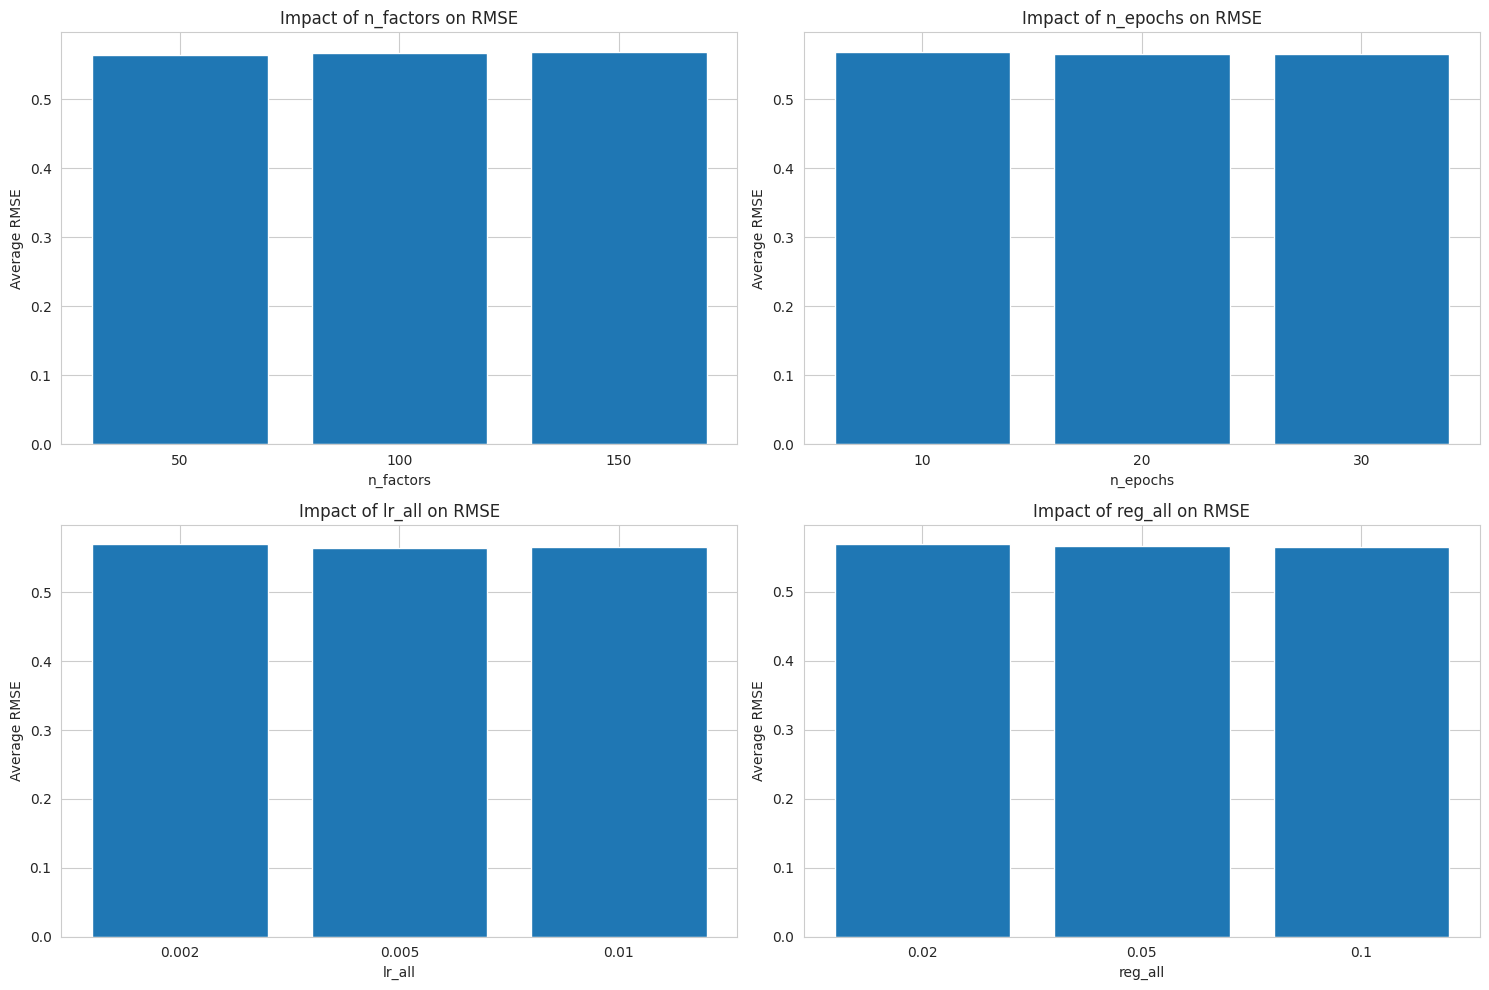

Visualizations saved to docs/hyperparameter_impact.png


In [29]:
# Cell 7: Visualize Parameter Impact
"""
Create visualizations to understand parameter impact on performance
"""

import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame(gs.cv_results)

# Create subplots for each parameter
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: n_factors impact
param_impact = results_df.groupby('param_n_factors')['mean_test_rmse'].mean()
axes[0, 0].bar(param_impact.index.astype(str), param_impact.values)
axes[0, 0].set_title('Impact of n_factors on RMSE')
axes[0, 0].set_xlabel('n_factors')
axes[0, 0].set_ylabel('Average RMSE')

# Plot 2: n_epochs impact
param_impact = results_df.groupby('param_n_epochs')['mean_test_rmse'].mean()
axes[0, 1].bar(param_impact.index.astype(str), param_impact.values)
axes[0, 1].set_title('Impact of n_epochs on RMSE')
axes[0, 1].set_xlabel('n_epochs')
axes[0, 1].set_ylabel('Average RMSE')

# Plot 3: lr_all impact
param_impact = results_df.groupby('param_lr_all')['mean_test_rmse'].mean()
axes[1, 0].bar(param_impact.index.astype(str), param_impact.values)
axes[1, 0].set_title('Impact of lr_all on RMSE')
axes[1, 0].set_xlabel('lr_all')
axes[1, 0].set_ylabel('Average RMSE')

# Plot 4: reg_all impact
param_impact = results_df.groupby('param_reg_all')['mean_test_rmse'].mean()
axes[1, 1].bar(param_impact.index.astype(str), param_impact.values)
axes[1, 1].set_title('Impact of reg_all on RMSE')
axes[1, 1].set_xlabel('reg_all')
axes[1, 1].set_ylabel('Average RMSE')

plt.tight_layout()
# Sauvegarde le graphique dans docs
plt.savefig('../docs/phase3_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved to docs/hyperparameter_impact.png")

In [30]:
# Cell 8: Fine-Tuned Grid Search
"""
Based on coarse results, perform fine-tuned search
Focus on promising parameter ranges
"""

# Based on coarse results, define fine-tuned grid
# (Update these based on your coarse search results)
param_grid_fine = {
    'n_factors': [90, 100, 110],  # If 100 was best
    'n_epochs': [18, 20, 22],      # If 20 was best
    'lr_all': [0.004, 0.005, 0.006],  # If 0.005 was best
    'reg_all': [0.015, 0.02, 0.025]   # If 0.02 was best
}

print("Fine-tuned parameter grid:")
for param, values in param_grid_fine.items():
    print(f"  {param}: {values}")

print("\\nStarting fine-tuned grid search...")

# Run fine-tuned search
gs_fine = GridSearchCV(
    SVD,
    param_grid_fine,
    measures=['rmse', 'mae'],
    cv=5,
    n_jobs=-1
)

gs_fine.fit(data)

print(f"Best fine-tuned RMSE: {gs_fine.best_score['rmse']:.4f}")
print("Best fine-tuned parameters:")
for param, value in gs_fine.best_params['rmse'].items():
    print(f"  {param}: {value}")

Fine-tuned parameter grid:
  n_factors: [90, 100, 110]
  n_epochs: [18, 20, 22]
  lr_all: [0.004, 0.005, 0.006]
  reg_all: [0.015, 0.02, 0.025]
\nStarting fine-tuned grid search...
Best fine-tuned RMSE: 0.5628
Best fine-tuned parameters:
  n_factors: 100
  n_epochs: 20
  lr_all: 0.006
  reg_all: 0.025


In [33]:
# Cell 9: Test Final Parameters on Full Dataset
"""
Test the optimal parameters on the full dataset
"""

print("Loading full dataset for final testing...")
ratings_full = loader.load_ratings()  # Full dataset
ratings_full_filtered = preprocessor.filter_cold_start_users(min_ratings=5)

print(f"Full dataset: {len(ratings_full_filtered)} ratings")

# Prepare full data
data_full = Dataset.load_from_df(
    ratings_full_filtered[['userId', 'movieId', 'rating']], 
    reader
)

# Train with best parameters
best_params = gs_fine.best_params['rmse']
print(f"\\nTraining on full dataset with best parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Cross-validate on full dataset
algo = SVD(**best_params)
cv_results = cross_validate(
    algo, 
    data_full, 
    measures=['RMSE', 'MAE'],
    cv=5,
    verbose=True
)

print("\\nFinal Results on Full Dataset:")
print(f"RMSE: {np.mean(cv_results['test_rmse']):.4f} (+/- {np.std(cv_results['test_rmse']):.4f})")
print(f"MAE:  {np.mean(cv_results['test_mae']):.4f} (+/- {np.std(cv_results['test_mae']):.4f})")

Loading full dataset for final testing...
Full dataset: 19534 ratings
\nTraining on full dataset with best parameters:
  n_factors: 100
  n_epochs: 20
  lr_all: 0.006
  reg_all: 0.025
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5671  0.5690  0.5624  0.5666  0.5662  0.5662  0.0022  
MAE (testset)     0.4603  0.4652  0.4578  0.4598  0.4565  0.4599  0.0030  
Fit time          0.29    0.29    0.28    0.27    0.29    0.28    0.01    
Test time         0.02    0.02    0.02    0.24    0.02    0.06    0.09    
\nFinal Results on Full Dataset:
RMSE: 0.5662 (+/- 0.0022)
MAE:  0.4599 (+/- 0.0030)


In [34]:
# Cell 10: Save Final Hyperparameters
"""
Save the optimal hyperparameters for use in production
"""

optimal_hyperparameters = {
    'n_factors': best_params['n_factors'],
    'n_epochs': best_params['n_epochs'],
    'lr_all': best_params['lr_all'],
    'reg_all': best_params['reg_all'],
    'random_state': 42,
    'performance': {
        'rmse': float(np.mean(cv_results['test_rmse'])),
        'rmse_std': float(np.std(cv_results['test_rmse'])),
        'mae': float(np.mean(cv_results['test_mae'])),
        'mae_std': float(np.std(cv_results['test_mae']))
    },
    'dataset_size': len(ratings_full_filtered),
    'timestamp': datetime.now().isoformat()
}

# Save to JSON
with open('../models/optimal_hyperparameters.json', 'w') as f:
    json.dump(optimal_hyperparameters, f, indent=2)

print("Optimal hyperparameters saved to ../models/optimal_hyperparameters.json")
print("\\nSummary:")
print(json.dumps(optimal_hyperparameters, indent=2))

Optimal hyperparameters saved to ../models/optimal_hyperparameters.json
\nSummary:
{
  "n_factors": 100,
  "n_epochs": 20,
  "lr_all": 0.006,
  "reg_all": 0.025,
  "random_state": 42,
  "performance": {
    "rmse": 0.5662477482042699,
    "rmse_std": 0.002158764462675075,
    "mae": 0.459921993828199,
    "mae_std": 0.0029616665228283205
  },
  "dataset_size": 19534,
  "timestamp": "2025-11-12T15:30:38.316989"
}
